<a href="https://colab.research.google.com/github/samyaknd/phishing-email-classifier/blob/main/phishing_email_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
import spacy
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from multiprocessing import Pool, cpu_count
from collections import Counter


# 1. Data Loading and Cleaning

In [29]:
#Loading data

raw_data = pd.read_csv('/content/sample_data/Phishing_Email.csv')
raw_data.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [30]:
raw_data.dtypes
raw_data.info()
df = raw_data.where(pd.notnull(raw_data), '')
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


(18650, 3)

In [55]:
df.rename(columns={'Email Text': 'text', 'Target': 'target'}, inplace=True)
df.sample(5)

,text,target
2231,re : migration request i have replace the old ...,1
17476,teaching job of french and german in korea fre...,1
8610,re : re : good the museum of the faculty of me...,0
3571,your anticipated assistant is required . i am ...,0
11581,"2 things - first, the switch parser changed in...",1


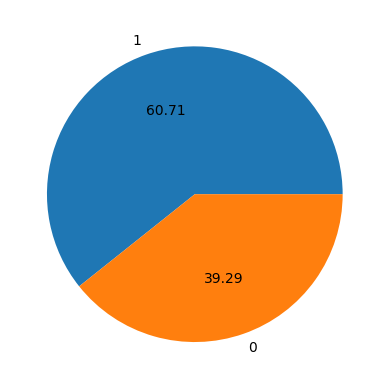

,text,target
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1
1,the other side of * galicismos * * galicismo *...,1
2,re : equistar deal tickets are you still avail...,1
3,\nHello I am your hot lil horny toy.\n I am...,0
4,software at incredibly low prices ( 86 % lower...,0


In [64]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
plt.pie(df['target'].value_counts(), labels=['1','0'],autopct="%0.2f")
plt.show()
df.head()

#After encoding Phishing Email = 0 and Safe Email = 1

# 2. EDA:

**Initial Data Evaluation and target variable decision:** Go through each data field. what type of data is it. What is the definition?

**Data duplications**: Find out the duplicate values and remove them from the dataset.

**Explore our data:** Explore the data. Decribe it. Check dtype and info.

**Null value detection:** Check if there are any null values in dataset and deiced how to deal with them. We can remove the data set with null values or we can replace them with an empty string.


I am going to do some feature extraction to better under the data. I used the NLTK punkt tokenizer to  split text into sentences. This tokenizer is needed for subsequent calculations involving sentence counts.

These features help me understand the characteristics of emails in the dataset (length, complexity, etc.) and potentially identify patterns related to the target variable (phishing vs safe emails).

In [144]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,text,target,num_characters,num_words,num_sentences
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1,1030,230,10
1,the other side of * galicismos * * galicismo *...,1,479,91,7
2,re : equistar deal tickets are you still avail...,1,1245,305,8
3,\nHello I am your hot lil horny toy.\n I am...,0,688,116,8
4,software at incredibly low prices ( 86 % lower...,0,441,91,13


Now I will look at the summary statistics for the newly created features (num_characters, num_words, and num_sentences). It give me a feel of the central tendency, spread, and potential outliers in the distribution of these features for different email categories.

In [78]:
phishing_stats = df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()
pd.options.display.float_format = '{:.2f}'.format
print("\nStatistics for Phishing Emails:")
print(phishing_stats)
average_num_words = df[df['target'] == 0]['num_words'].mean()
print(f"\n\nAverage number of words in phishing emails: {average_num_words:.2f}")
pd.options.display.float_format = None  # Resets to default format


       num_characters  num_words  num_sentences
count        11322.00   11322.00       11322.00
mean          3493.01     720.97          40.19
std         160168.02   34062.13        2098.65
min              5.00       1.00           1.00
25%            444.00      90.00           4.00
50%            994.50     205.00           9.00
75%           2029.75     415.75          19.00
max       17036692.00 3623496.00      223247.00
Average number of words in phishing emails: 720.97


In [84]:
safe_stats = df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()
pd.options.display.float_format = '{:.2f}'.format
print("\nStatistics for Safe Emails:")
print(safe_stats)
average_num_words_safe = df[df['target'] == 0]['num_words'].mean()
print(f"\n\nAverage number of words in safe emails: {average_num_words_safe:.2f}")
pd.options.display.float_format = None  # Resets to default format



Statistics for Safe Emails:
       num_characters  num_words  num_sentences
count         7328.00    7328.00        7328.00
mean          1610.40     322.37          19.85
std           3349.38     619.21          52.22
min              0.00       0.00           0.00
25%            353.00      72.00           5.00
50%            731.00     147.00          10.00
75%           1566.25     313.25          19.00
max         129635.00   13291.00        3093.00

Average number of words in safe emails: 322.37


**Observations:**

**Overall Length:**\
Safe emails tend to be shorter on average compared to phishing emails. This is evident from the mean values for num_characters (1610.4 for safe vs. 3493.01 for phishing).

**Word Count:**\
Safe emails also have a lower average word count than phishing emails (322.37 for safe vs. 720.97 for phishing).

**Sentence Structure:**\
Both safe and phishing emails seem to have a similar average number of sentences (around 20 sentences per email).

**Distribution of Length and Word Count**:\
The standard deviation (std) values for num_characters and num_words are much higher for phishing emails compared to safe emails. This indicates a wider distribution of lengths and word counts in phishing emails. Looking at the minimum and maximum values further confirms this broader range for phishing emails.

**Potential Implications:**\
Phishing emails might be deliberately crafted to be concise and persuasive, hence their shorter length and lower word count on average.
The wider distribution in length and word count for phishing emails suggests they might come in various formats, unlike safe emails which might exhibit a more consistent structure.
Important Caveats:

Further analysis with visualizations (histograms, boxplots) might reveal more insights.


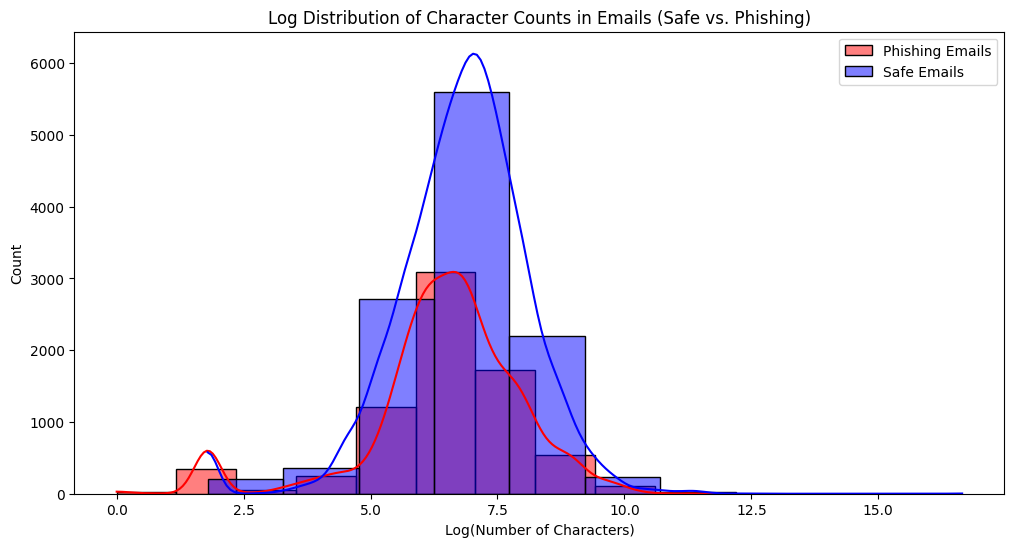

In [106]:
plt.figure(figsize=(12, 6))
df['log_num_characters'] = np.log1p(df['num_characters'])
sns.histplot(df[df['target'] == 0]['log_num_characters'], bins=10, label='Phishing Emails', color='red', kde=True)
sns.histplot(df[df['target'] == 1]['log_num_characters'], bins=10, label='Safe Emails', color='blue', kde=True)
plt.xlabel("Log(Number of Characters)")
plt.ylabel("Count")
plt.title("Log Distribution of Character Counts in Emails (Safe vs. Phishing)")
plt.legend()
plt.show()

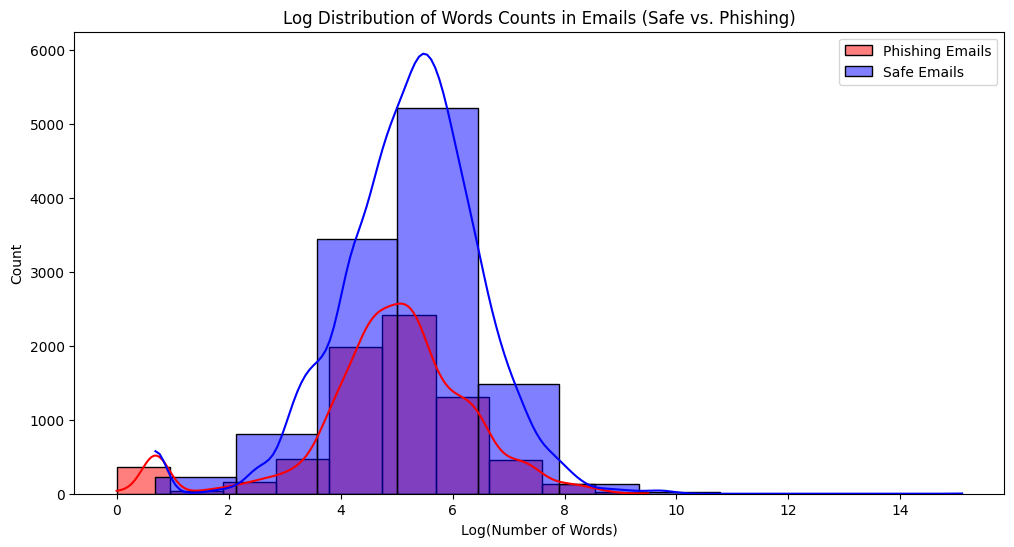

In [107]:
plt.figure(figsize=(12, 6))
df['log_num_words'] = np.log1p(df['num_words'])
sns.histplot(df[df['target'] == 0]['log_num_words'], bins=10, label='Phishing Emails', color='red', kde=True)
sns.histplot(df[df['target'] == 1]['log_num_words'], bins=10, label='Safe Emails', color='blue', kde=True)
plt.xlabel("Log(Number of Words)")
plt.ylabel("Count")
plt.title("Log Distribution of Words Counts in Emails (Safe vs. Phishing)")
plt.legend()
plt.show()

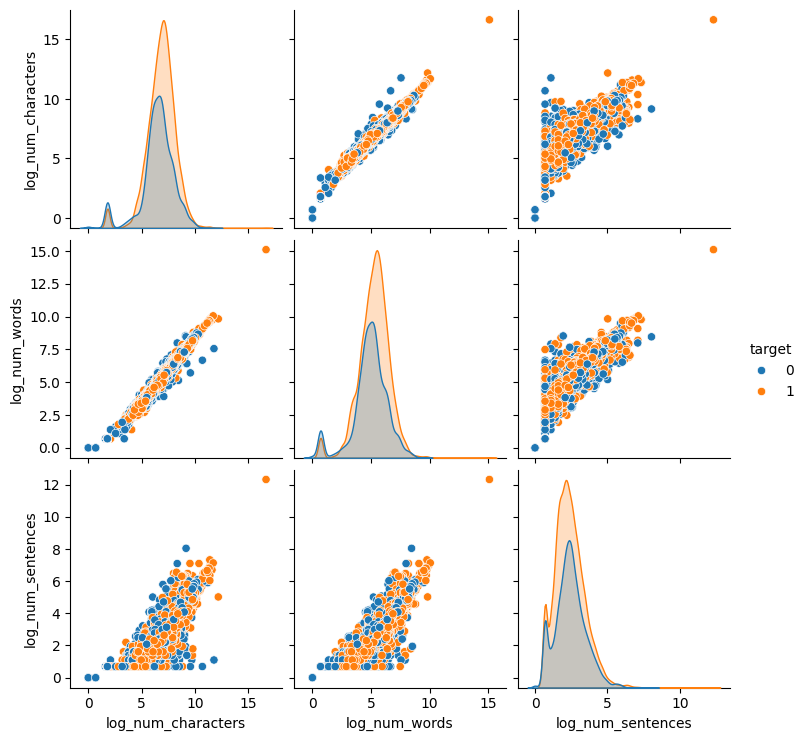

In [111]:
df['log_num_characters'] = np.log1p(df['num_characters'])
df['log_num_words'] = np.log1p(df['num_words'])
df['log_num_sentences'] = np.log1p(df['num_sentences'])
selected_columns = ['log_num_characters', 'log_num_words', 'log_num_sentences', 'target']
sns.pairplot(df[selected_columns], hue='target')
plt.show()

<Axes: >

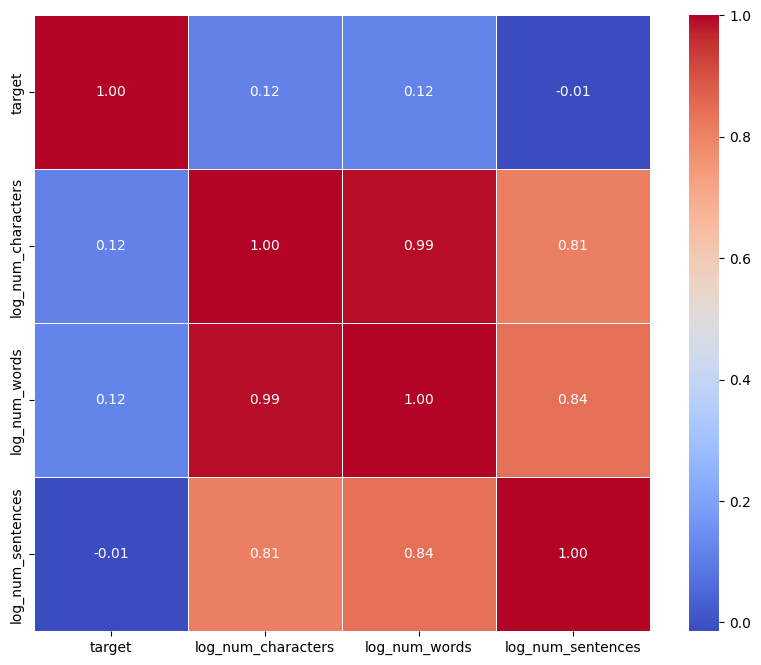

In [125]:
log_columns = ['target','log_num_characters', 'log_num_words', 'log_num_sentences']
correlation_matrix = df[log_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)


**Observations:**

Safe emails: There is a tendency towards shorter character counts.

Phishing emails: The red bars are spread out more, suggesting a wider range of character counts in phishing emails. There might be a higher proportion of phishing emails with both very low and very high character counts compared to safe emails.

The heatmap suggests that the number of words, characters and sentences are strongly correlated.

# 3. Data Preprosessing:
*   Lower Case
*   Tokenization
*   Removing special characters
*   Removing stop words and punctuation
*   Stemming

In [146]:
ps = PorterStemmer()
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 20000000

def transform_text(text):
    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove stop words and punctuation using SpaCy
    doc = nlp(text)
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]

    # Stemming
    tokens = [ps.stem(token) for token in tokens]

    return " ".join(tokens)

# Define a function to apply the transformation to a DataFrame chunk
def transform_texts(df_chunk):
    df_chunk['transformed_text'] = df_chunk['text'].apply(transform_text)
    return df_chunk

# Split the DataFrame into chunks based on the number of CPU cores
def split_dataframe(df, num_chunks):
    chunk_size = len(df) // num_chunks
    return [df[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]

# Apply the transformation using multiprocessing
def parallelize_dataframe(df, func):
    num_cores = cpu_count()
    df_chunks = split_dataframe(df, num_cores)
    with Pool(num_cores) as pool:
        df_processed = pd.concat(pool.map(func, df_chunks))
    return df_processed

# Apply the transformation in parallel
df_processed = parallelize_dataframe(df, transform_texts)
df_processed.head()

KeyboardInterrupt: 